# **CLASSIFICATION**

In [1]:
import sys
sys.path.insert(0, '../src/')

import pickle
import pandas as pd
import auto_co2 as co2
from auto_co2 import viz
file_path = "../data/processed/co2_classification_dataset_fr-de-2021.csv"


# Convert the loaded data to a DataFrame
df = pd.read_csv(file_path)
display(df.head())

,MassRunningOrder,BaseWheel,EnginePower,InnovativeTechnology,ElecRange_NO_RANGE,ElecRange_0to50,ElecRange_50to100,ElecRange_100to150,ElecRange_150+,Pool_BMW,...,FuelType_DIESEL/ELECTRIC,FuelType_E85,FuelType_ELECTRIC,FuelType_HYDROGEN,FuelType_LPG,FuelType_NG,FuelType_NG-BIOMETHANE,FuelType_PETROL,FuelType_PETROL/ELECTRIC,Co2Grade
0,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,A
1,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,A
2,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,A
3,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,A
4,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,A


In [2]:
%pwd

'/home/mln/GIT/car-co2-prediction_pre-release/notebooks'

In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import shap

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Ce code accomplit plusieurs choses :

pd.set_option('display.max_columns', None) et pd.set_option('display.max_rows', 100) : Ces lignes utilisent des fonctionnalités de Pandas pour définir les options d'affichage. Elles modifient les paramètres pour permettre l'affichage de toutes les colonnes (sans troncature) et limitent l'affichage à 100 lignes maximum dans une cellule ou un tableau.

from sklearn.model_selection import train_test_split, from sklearn.tree import DecisionTreeClassifier, from sklearn.ensemble import RandomForestClassifier : Ces lignes importent des classes ou des fonctions spécifiques de la bibliothèque scikit-learn (sklearn).

train_test_split est utilisé pour diviser les données en ensembles d'entraînement et de test.
DecisionTreeClassifier et RandomForestClassifier sont des algorithmes de classification basés sur les arbres de décision et les forêts aléatoires respectivement.
import warnings warnings.simplefilter(action='ignore', category=FutureWarning) : Cette partie importe le module warnings et configure le filtrage pour ignorer les avertissements de type FutureWarning. Cela peut être utile lorsque des avertissements spécifiques sont jugés non critiques pour l'exécution du code.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177887 entries, 0 to 4177886
Data columns (total 30 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MassRunningOrder                 float64
 1   BaseWheel                        float64
 2   EnginePower                      float64
 3   InnovativeTechnology             int64  
 4   ElecRange_NO_RANGE               int64  
 5   ElecRange_0to50                  int64  
 6   ElecRange_50to100                int64  
 7   ElecRange_100to150               int64  
 8   ElecRange_150+                   int64  
 9   Pool_BMW                         int64  
 10  Pool_FORD                        int64  
 11  Pool_HYUNDAI                     int64  
 12  Pool_KIA                         int64  
 13  Pool_MAZDA-SUBARU-SUZUKI-TOYOTA  int64  
 14  Pool_MERCEDES-BENZ               int64  
 15  Pool_RENAULT-NISSAN-MITSUBISHI   int64  
 16  Pool_STELLANTIS                  int64  
 17  Pool_TES

In [5]:
target = df['Co2Grade']
data = df.drop(columns='Co2Grade')

data.head()

,MassRunningOrder,BaseWheel,EnginePower,InnovativeTechnology,ElecRange_NO_RANGE,ElecRange_0to50,ElecRange_50to100,ElecRange_100to150,ElecRange_150+,Pool_BMW,...,FuelType_DIESEL,FuelType_DIESEL/ELECTRIC,FuelType_E85,FuelType_ELECTRIC,FuelType_HYDROGEN,FuelType_LPG,FuelType_NG,FuelType_NG-BIOMETHANE,FuelType_PETROL,FuelType_PETROL/ELECTRIC
0,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1598.0,2558.0,57.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
target.head()

0    A
1    A
2    A
3    A
4    A
Name: Co2Grade, dtype: object

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)

Ce code utilise la fonction train_test_split de la bibliothèque scikit-learn pour diviser les données en ensembles d'entraînement et de test, généralement utilisés dans le cadre de l'apprentissage supervisé où vous avez des variables indépendantes (data dans ce cas) et une variable cible (target).

Voici ce que chaque partie signifie :

data : C'est le jeu de données contenant les caractéristiques (variables indépendantes) que vous utiliserez pour entraîner votre modèle.
target : C'est la variable cible que vous essayez de prédire ou de modéliser.
La fonction train_test_split divise ces données en quatre parties distinctes :

X_train : C'est la partie du jeu de données data qui sera utilisée pour entraîner votre modèle.
X_test : C'est la partie du jeu de données data qui sera utilisée pour tester la performance de votre modèle, une fois qu'il est entraîné.
y_train : C'est la partie de la variable cible (target) correspondant aux données d'entraînement (X_train).
y_test : C'est la partie de la variable cible (target) correspondant aux données de test (X_test).
Les arguments utilisés dans la fonction train_test_split sont :

test_size=.2 : Il s'agit de la proportion des données qui seront attribuées à l'ensemble de test. Ici, 20% des données sont réservées pour le test.
random_state=42 : Cet argument fixe la graine aléatoire pour garantir la reproductibilité. En utilisant la même valeur (42 dans ce cas), les résultats de la division seront les mêmes à chaque exécution du code.
En somme, cette ligne de code crée quatre ensembles de données : un ensemble d'entraînement pour les caractéristiques (X_train), un

In [8]:
def plot_confusion_matrix(y_true, y_pred, cmap='Blues', title=''):
    cm = confusion_matrix(y_true, y_pred)
    classes = range(0, 10)
    plt.figure(figsize=(6,6))

    sns.set_style("whitegrid", {"axes.grid": False})
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels=classes)
    plt.yticks(tick_marks, labels=classes)
    img = plt.imshow(cm, cmap=cmap, interpolation='nearest')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
        horizontalalignment='center',
        verticalalignment='center', 
        color='white' if cm[i,j] > cm.max() / 2 else 'black')

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.title(f"Matrice de confusion {title}")
    plt.show()

## **DECISION TREES**

On initialise un objet de la classe `DecisionTreeClassifier`.  
Il y aura une profondeur maximum de 20 branches, car c'est la valeur opimale du rapport performances / puissance de calcul.
L'arbre de décision est ensuite entraîné sur les données d'entraînement, puis sa performance est évaluée sur le jeu de test.  

Les performances sont bonnes, avec une accuracy de 94% et les prévisions des classes sont plutôt bien équilibrées. 
On a en effet un score f1 réparti entre 92% et 100%.  
Nous gardons en en tête que les performances des arbres de décisions peuvent démontrer un problème de surajustement sous-jacent (overfitting).  
Nous allons donc devoir le comparer à d'autres modèles.

In [9]:
%%time
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20)
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00    197120
           B       0.91      0.95      0.93    141817
           C       0.94      0.93      0.93    270657
           D       0.92      0.91      0.92    130460
           E       0.95      0.93      0.94     66734
           F       0.95      0.96      0.95     22507
           G       0.97      0.96      0.97      6283

    accuracy                           0.95    835578
   macro avg       0.95      0.95      0.95    835578
weighted avg       0.95      0.95      0.95    835578

CPU times: user 20.5 s, sys: 67.8 ms, total: 20.6 s
Wall time: 20.6 s


On va étudier l'ordre d'importance de nos features.  
Sur plusieurs essais, l'importance des caractéristiques `"EnginePower"` et `"MassRunningOrder"` dominent nettement pour la classification par arbre de décision

In [10]:
feats = {}
for feature, importance in zip(data.columns, dtc.feature_importances_):
    feats[feature] = importance

importances  = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'importance'})
importances = importances.sort_values(by='importance', ascending=False)
importances

,importance
EnginePower,2.412286e-01
MassRunningOrder,2.216342e-01
ElecRange_NO_RANGE,1.821974e-01
BaseWheel,1.306374e-01
FuelType_ELECTRIC,9.227010e-02
FuelType_PETROL,2.689555e-02
FuelType_PETROL/ELECTRIC,2.150191e-02
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,1.883482e-02
InnovativeTechnology,1.032425e-02
Pool_FORD,8.160507e-03


Voici le cheminement logique des 2 premières étapes logiques depuis le noyau. L'arbre commence par trier les véhicules par leur autonomie du moteur électrique (hybrides), puis par la puissance du moteur.  
On remarque que le coefficient gini passe à des valeurs quasi nulles sur la branche de droite, l'arbre peut en effet trouver la note des véhicules hybrides avec quasi-certitude dès le 2ème niveau de choix logiques.

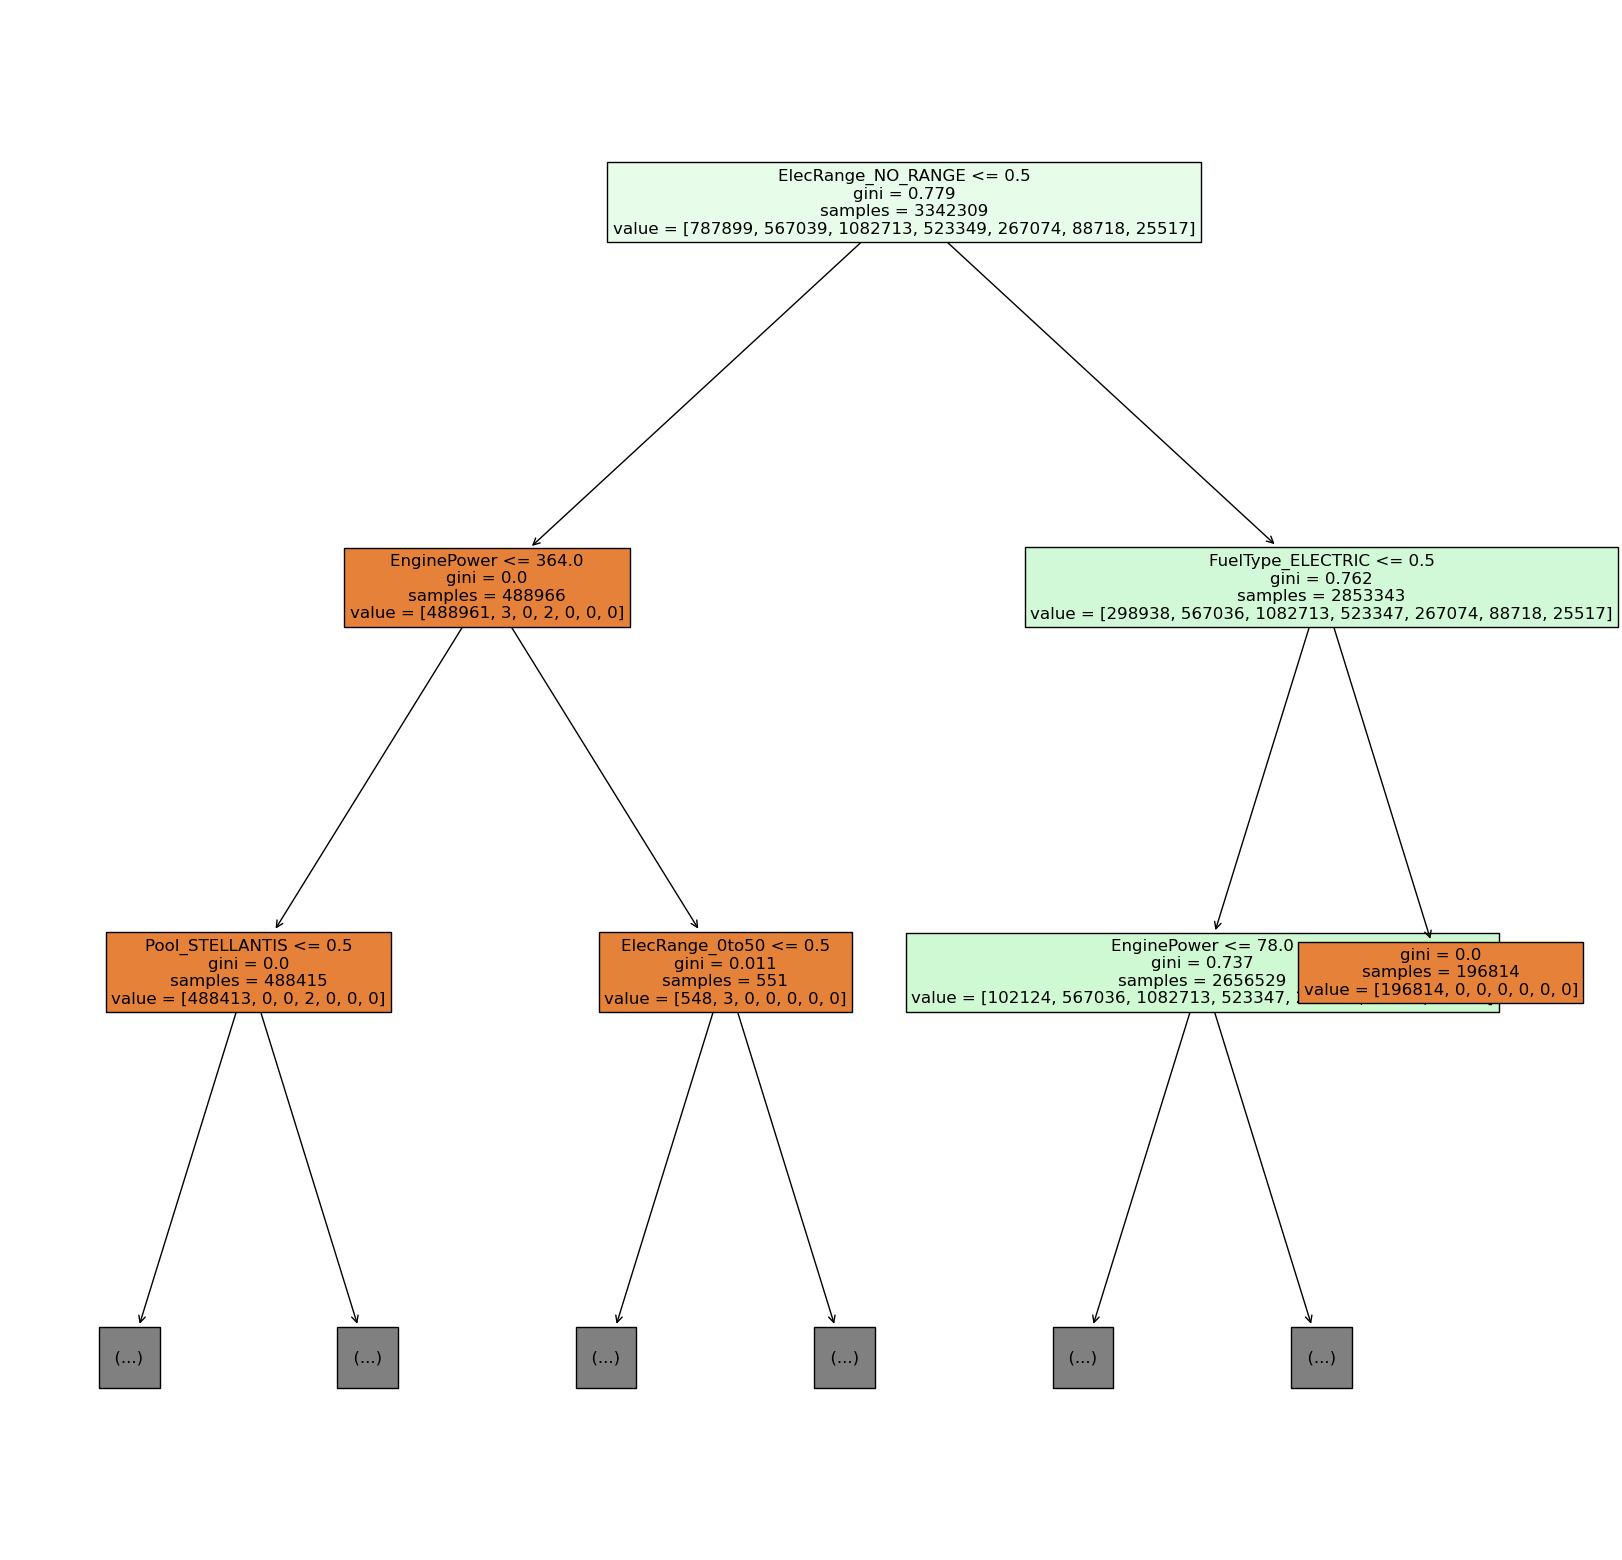

In [11]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 20))

plot_tree(dtc, feature_names=X_train.columns.tolist(),
          max_depth=2, filled=True, fontsize=12);

## **RANDOM FOREST** 

Les résultats du décision tree montrent que les modèles logiques vont donner de bons, nous allons donc essayer un modèle logique plus élaboré, avec un algorithme de Random Forest.  

Les performances sont similaires, mais le temps d'exécution est sensiblement plus long. 
Ce désavantage doit être nuancé par le fait que les performances de modèles de forêt aléatoire sont généralement plus robustes que les arbres de décisions quand ils sont confrontés à de nouvelles données.  

In [12]:
%%time
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00    197120
           B       0.91      0.95      0.93    141817
           C       0.94      0.93      0.93    270657
           D       0.92      0.91      0.92    130460
           E       0.95      0.94      0.94     66734
           F       0.95      0.96      0.96     22507
           G       0.97      0.96      0.97      6283

    accuracy                           0.95    835578
   macro avg       0.95      0.95      0.95    835578
weighted avg       0.95      0.95      0.95    835578

CPU times: user 22min 14s, sys: 5.38 s, total: 22min 19s
Wall time: 1min 48s


In [13]:
print(sys.path)

['../src/', '/home/mln/GIT/car-co2-prediction_pre-release/notebooks', '/home/mln/miniconda3/envs/co2/lib/python39.zip', '/home/mln/miniconda3/envs/co2/lib/python3.9', '/home/mln/miniconda3/envs/co2/lib/python3.9/lib-dynload', '', '/home/mln/miniconda3/envs/co2/lib/python3.9/site-packages']


In [14]:
viz.plot_confusion_matrix(y_test, rfc_pred, 'Greens')

In [15]:
feats = {}
for feature, importance in zip(data.columns, rfc.feature_importances_):
    feats[feature] = importance

importances  = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'importance'})
importances['importance'] *= 100
importances = importances.sort_values(by='importance', ascending=False)
importances

,importance
MassRunningOrder,28.554365
EnginePower,19.207778
BaseWheel,14.355159
FuelType_ELECTRIC,6.298240
ElecRange_NO_RANGE,6.108666
FuelType_PETROL,4.726167
FuelType_DIESEL,4.219415
InnovativeTechnology,3.681976
FuelType_PETROL/ELECTRIC,3.057137
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,1.531639


## **Réduction de dimensions PCA appliquée sur un modèle Random Forest**

In [16]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, target, test_size=.2, random_state=42)

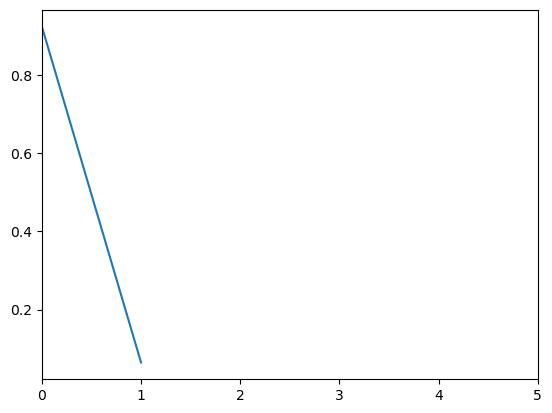

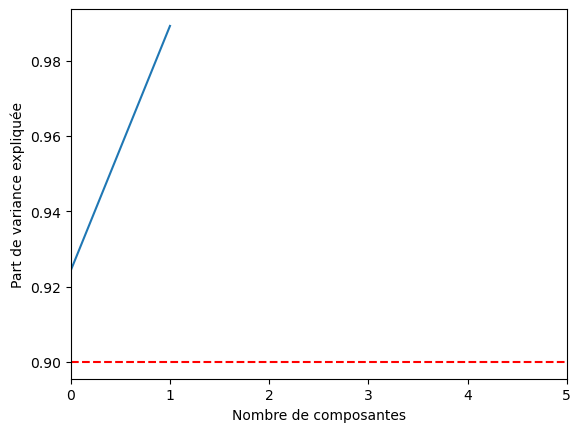

In [17]:
plt.figure()

plt.xlim(0,5)
plt.plot(pca.explained_variance_ratio_)


plt.figure()
plt.xlim(0,5)
plt.xlabel('Nombre de composantes')
plt.ylabel('Part de variance expliquée')
plt.axhline(y=.9, color='r', linestyle='--')
plt.plot(pca.explained_variance_ratio_.cumsum())

In [18]:
%%time
rfc_pca = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=-1, random_state=42)
rfc_pca.fit(X_train_pca, y_train_pca)

rfc_pca_pred = rfc_pca.predict(X_test_pca)
print(classification_report(y_test_pca, rfc_pca_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00    197120
           B       0.91      0.95      0.93    141817
           C       0.94      0.93      0.93    270657
           D       0.92      0.91      0.92    130460
           E       0.95      0.94      0.94     66734
           F       0.95      0.96      0.96     22507
           G       0.97      0.96      0.97      6283

    accuracy                           0.95    835578
   macro avg       0.95      0.95      0.95    835578
weighted avg       0.95      0.95      0.95    835578

CPU times: user 18min 14s, sys: 5.64 s, total: 18min 19s
Wall time: 1min 32s


## **Modèle d'ensemble: XGBoost**

Nous allons maintenant voir un modèle de gradient boosting avec XGBoost, la librairie la plus populaire.  
Les algorithmes XGBoost montrent généralement de très bonnes performances sur des problèmes de classification multi-classe.    
Ces algorithmes sont basés sur des ensembles d'arbres de décisions, dans le boosting, chaque arbre de décision tente de corriger les erreurs de l'arbre précédent. 

#### **Le modèle XGBoostClassifier**
C'est l'algorithme propre à la classification. 
Il ne nécessite pas de créer une XDmatrix, nous devons en revanche encoder les classes de la cible en integers.  


Nous lui demandons: 
- De générer itérativement 400 arbres de décision
- De tenir compte de nos 7 classes possibles pour la cible
- De s'arrêter si aucune amélioration n'est obsevée sur 20 itérations consécutives
- D'évaluer la performance sur les moyennes d'erreurs et log-loss (divergences entre les probabilités prédites et les classes réelles)

In [19]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


encoder = LabelEncoder()
target_enc = encoder.fit_transform(target)

X_x, X_valid_x, y_x, y_valid_x = train_test_split(data, target_enc, test_size=.1)
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_x, y_x, test_size=.2, random_state=42)



In [20]:
%%time

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            n_estimators=400,
                            num_class=7, 
                            early_stopping_rounds=20, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            verbosity=2)



CPU times: user 26 µs, sys: 1e+03 ns, total: 27 µs
Wall time: 29.3 µs


In [21]:
%%time
xgb_clf.fit(X_train_x, y_train_x, eval_set=[(X_train_x, y_train_x), (X_test_x, y_test_x)])

[0]	validation_0-merror:0.16015	validation_0-mlogloss:1.30848	validation_1-merror:0.16013	validation_1-mlogloss:1.30830
[1]	validation_0-merror:0.14444	validation_0-mlogloss:1.04381	validation_1-merror:0.14413	validation_1-mlogloss:1.04365
[2]	validation_0-merror:0.14151	validation_0-mlogloss:0.87550	validation_1-merror:0.14147	validation_1-mlogloss:0.87534
[3]	validation_0-merror:0.13203	validation_0-mlogloss:0.74419	validation_1-merror:0.13197	validation_1-mlogloss:0.74404
[4]	validation_0-merror:0.13629	validation_0-mlogloss:0.65435	validation_1-merror:0.13599	validation_1-mlogloss:0.65408
[5]	validation_0-merror:0.13247	validation_0-mlogloss:0.58544	validation_1-merror:0.13216	validation_1-mlogloss:0.58517
[6]	validation_0-merror:0.12499	validation_0-mlogloss:0.53513	validation_1-merror:0.12466	validation_1-mlogloss:0.53480
[7]	validation_0-merror:0.12272	validation_0-mlogloss:0.49252	validation_1-merror:0.12252	validation_1-mlogloss:0.49217
[8]	validation_0-merror:0.12013	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

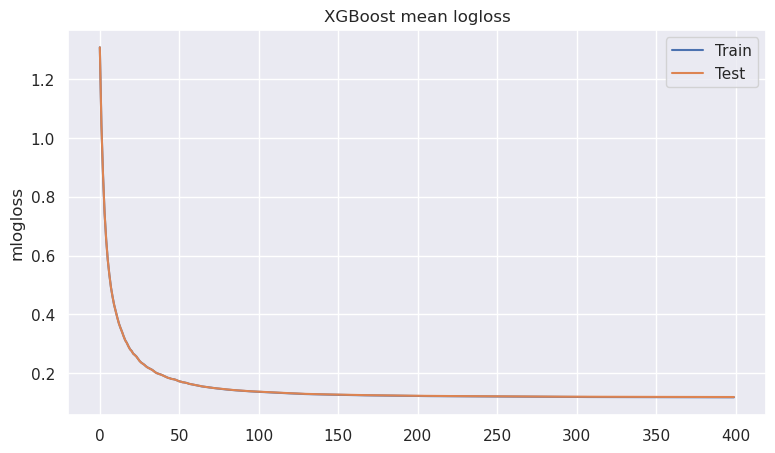

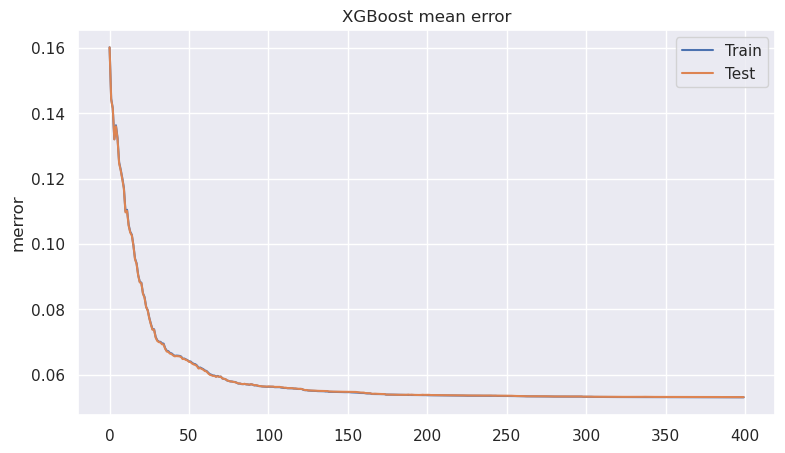

In [22]:
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
sns.set()
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mean logloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost mean error')
plt.show()

In [29]:
import plotly.graph_objects as go
x_axis = list(range(0, 400))
# xgboost 'mlogloss' plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['mlogloss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['mlogloss'], mode='lines', name='Test'))
fig.update_layout(title='XGBoost mean logloss', xaxis_title='Epoch', yaxis_title='mlogloss')
fig.show()



In [30]:
# xgboost 'merror' plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['merror'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['merror'], mode='lines', name='Test'))
fig.update_layout(title='XGBoost mean error', xaxis_title='Epoch', yaxis_title='merror')
fig.show()

Le gain en performances est considérable pour les 30 premières itérations, puis diminue de moitié avant d'atteindre l'itération 200.  
Les performances atteignent ensuite un plateau, il ne semble pas pertinent de procéder à plus de 400 itérations.  

Les performances de classification sont sensiblement les mêmes qu'avec un Random Forest. En revanche l'algorithme de boosting promet un modèle encore plus robuste. 

In [23]:
from sklearn.metrics import classification_report
xgb_pred = xgb_clf.predict(X_test_x)
print(classification_report(y_test_x, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177416
           1       0.92      0.94      0.93    127403
           2       0.94      0.93      0.93    243043
           3       0.92      0.91      0.92    118101
           4       0.95      0.93      0.94     60077
           5       0.94      0.97      0.95     20108
           6       0.99      0.95      0.97      5872

    accuracy                           0.95    752020
   macro avg       0.95      0.95      0.95    752020
weighted avg       0.95      0.95      0.95    752020



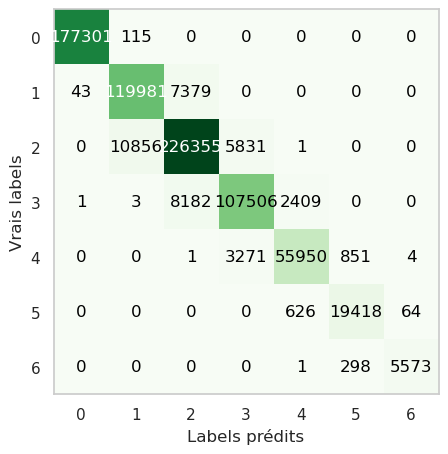

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
csn_matrix = confusion_matrix(y_test_x, xgb_pred)


classes = range(0, 10)
plt.figure(figsize=(5,5))

sns.set_style("whitegrid", {"axes.grid": False})
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels=classes)
plt.yticks(tick_marks, labels=classes)
img = plt.imshow(csn_matrix, cmap='Greens', interpolation='nearest')
for i, j in itertools.product(range(csn_matrix.shape[0]), range(csn_matrix.shape[1])):
    plt.text(j, i, csn_matrix[i,j],
    horizontalalignment='center',
    verticalalignment='center', 
    color='white' if csn_matrix[i,j] > csn_matrix.max() / 2 else 'black')

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

Voici le cheminement logique de référence de ce modèle de boosting

ImportError: You must install graphviz to plot tree

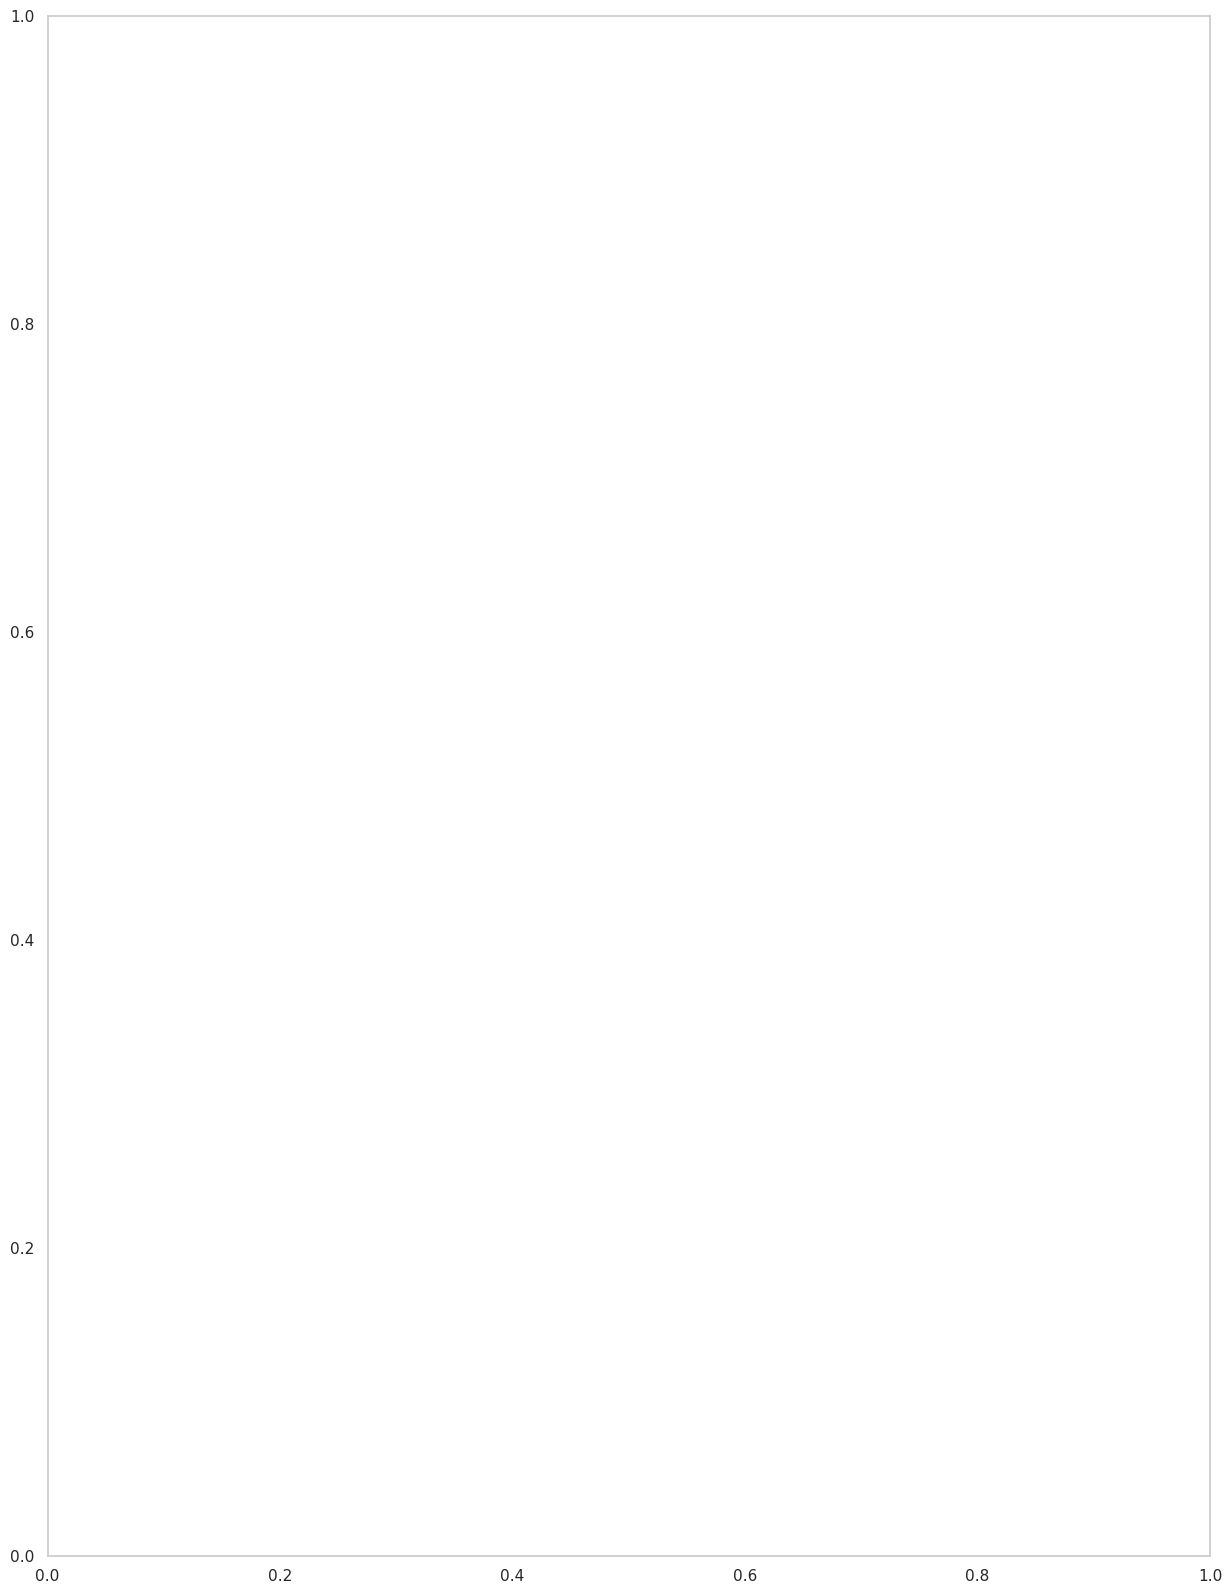

In [25]:
plt.rcParams['figure.figsize'] = 15, 20
xgb.plot_tree(xgb_clf, fig_size=(16,16))
plt.show()

<Figure size 700x500 with 0 Axes>

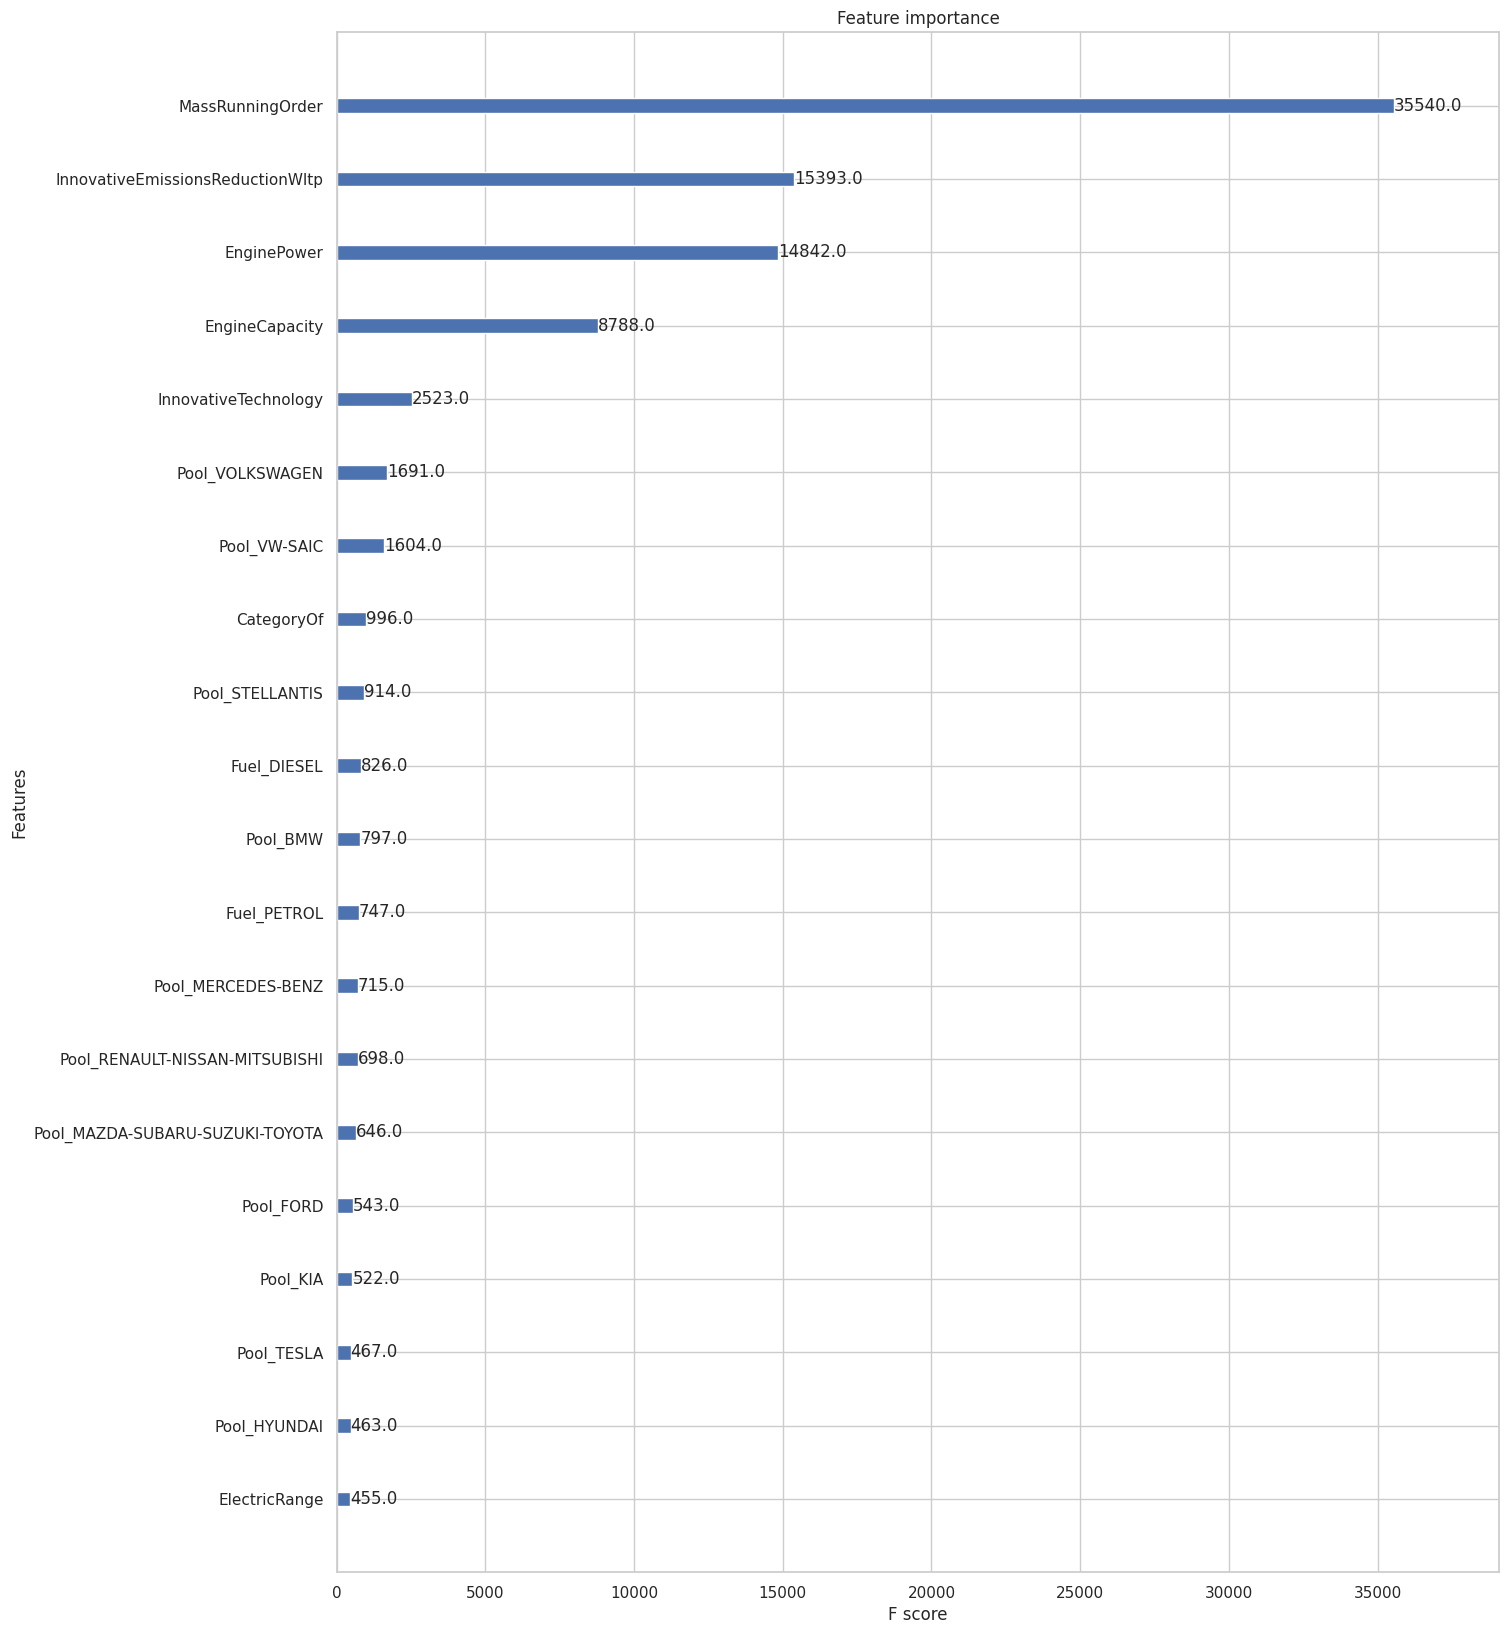

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
xgb.plot_importance(xgb_clf, max_num_features=20)
plt.show()

#### **Performances du modèle XGBoostClassifier sur le jeu de validation**

In [ ]:
xgb_valid_pred = xgb_clf.predict(X_valid_x)

# Display classification report
report = classification_report(y_valid_x, xgb_valid_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     75326
           1       0.92      0.95      0.93    124078
           2       0.94      0.93      0.93    235760
           3       0.92      0.91      0.92    111865
           4       0.95      0.93      0.94     56704
           5       0.95      0.96      0.95     21916
           6       0.95      0.95      0.95      6459

    accuracy                           0.94    632108
   macro avg       0.95      0.95      0.95    632108
weighted avg       0.94      0.94      0.94    632108



### **XGBoost2**

In [ ]:
%%time
train = xgb.DMatrix(data=X_train_x, label=y_train_x)
test = xgb.DMatrix(data=X_test_x, label=y_test_x)
valid = xgb.DMatrix(data=X_valid_x, label=y_valid_x)

params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'multi:softmax', 'eval_metric': 'mlogloss', 'num_class': 7}
xgb2 = xgb.train(params=params, dtrain=train, num_boost_round=400, early_stopping_rounds=10, evals=[(train, 'train'), (test, 'eval')])


[0]	train-mlogloss:1.92421	eval-mlogloss:1.92420
[1]	train-mlogloss:1.90300	eval-mlogloss:1.90297
[2]	train-mlogloss:1.88239	eval-mlogloss:1.88236
[3]	train-mlogloss:1.86250	eval-mlogloss:1.86247
[4]	train-mlogloss:1.84296	eval-mlogloss:1.84291
[5]	train-mlogloss:1.82406	eval-mlogloss:1.82401
[6]	train-mlogloss:1.80558	eval-mlogloss:1.80553
[7]	train-mlogloss:1.78754	eval-mlogloss:1.78749
[8]	train-mlogloss:1.77002	eval-mlogloss:1.76996
[9]	train-mlogloss:1.75258	eval-mlogloss:1.75252
[10]	train-mlogloss:1.73555	eval-mlogloss:1.73549
[11]	train-mlogloss:1.71922	eval-mlogloss:1.71915
[12]	train-mlogloss:1.70326	eval-mlogloss:1.70319
[13]	train-mlogloss:1.68766	eval-mlogloss:1.68759
[14]	train-mlogloss:1.67238	eval-mlogloss:1.67231
[15]	train-mlogloss:1.65734	eval-mlogloss:1.65727
[16]	train-mlogloss:1.64253	eval-mlogloss:1.64246
[17]	train-mlogloss:1.62810	eval-mlogloss:1.62803
[18]	train-mlogloss:1.61367	eval-mlogloss:1.61359
[19]	train-mlogloss:1.59959	eval-mlogloss:1.59951
[20]	train

In [ ]:
y_pred2 = xgb2.predict(test)
print(classification_report(y_test_x, y_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    135515
           1       0.90      0.84      0.87    224876
           2       0.82      0.91      0.87    423893
           3       0.84      0.71      0.77    201016
           4       0.84      0.87      0.86    101554
           5       0.92      0.89      0.90     39097
           6       0.95      0.91      0.93     11843

    accuracy                           0.87   1137794
   macro avg       0.90      0.88      0.89   1137794
weighted avg       0.87      0.87      0.87   1137794



In [ ]:
preds = xgb2.predict(test)
xgbpreds = pd.Series(np.where(preds > .5, 1, 0))

display(pd.crosstab(y_test_x, y_pred2, rownames=['Classes Réelles'], colnames=['Classes Prédites']))


Classes Prédites,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Classes Réelles,,,,,,,
0,135306,209,0,0,0,0,0
1,463,187849,36203,361,0,0,0
2,0,20033,387802,15723,335,0,0
3,0,25,46409,142417,12165,0,0
4,0,14,621,10569,88454,1896,0
5,0,0,0,0,3937,34648,512
6,0,0,0,0,13,995,10835


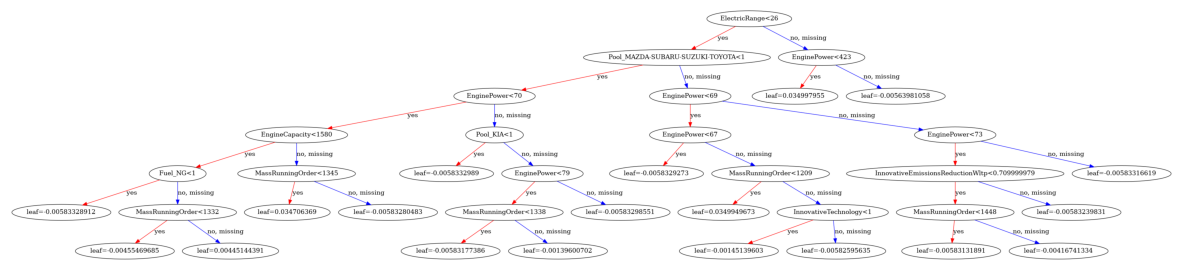

In [ ]:

from matplotlib.pylab import rcParams

#rcParams['figure.figsize'] = 20,20
xgb.plot_tree(xgb2, fig_size=(16,16))
plt.show()

## **Interprétation des modèles d'ensemble**

A l'aide de SHAP, nous allons maitnenant étudier l'interprétabilité de notre modèle xgb

In [ ]:
%%time
shap_sample = X_test_x.sample(10000, random_state=42)
explainer = shap.Explainer(xgb_clf.predict, shap_sample)
# Calculates the SHAP values - It takes some time
shap_values = explainer(shap_sample)

PermutationExplainer explainer: 10001it [14:11, 11.63it/s]                          


CPU times: user 3h 42min 30s, sys: 12 s, total: 3h 42min 42s
Wall time: 14min 12s


In [ ]:
import pickle

with open('explainer.pkl', 'wb') as explainer_file:
    pickle.dump(explainer, explainer_file)

with open('shap_values.pkl', 'wb') as shap_values_file:
    pickle.dump(shap_values, shap_values_file)
    
'''
with open('explainer.pkl', 'rb') as explainer_file:
    explainer = pickle.load(explainer_file)

with open('shap_values.pkl', 'rb') as shap_values_file:
    shap_values = pickle.load(shap_values_file)

'''


"\nwith open('explainer.pkl', 'rb') as explainer_file:\n    explainer = pickle.load(explainer_file)\n\nwith open('shap_values.pkl', 'rb') as shap_values_file:\n    shap_values = pickle.load(shap_values_file)\n\n"

In [ ]:
import numpy as np

# Save SHAP values to .npy file
np.save('shap_values.npy', shap_values)
np.save('explainer.npy', explainer)

# Load SHAP values from .npy file in Colab
#shap_values_loaded = np.load('/content/gdrive/My Drive/ROOT/Dataset/shap_values.npy')


In [ ]:
with open('xgb_clf.pkl', 'wb') as model_file:
    pickle.dump(xgb_clf, model_file)

In [ ]:
import numpy as np
import pandas as pd
import pickle

# Save SHAP values to CSV
shap_values_np = np.concatenate(shap_values, axis=0) if isinstance(shap_values, list) else np.array(shap_values)
shap_values_df = pd.DataFrame(shap_values_np, columns=shap_sample.columns)
shap_values_df.to_csv('shap_values.csv', index=False)

# Save explainer information to CSV
with open('explainer.csv', 'w') as explainer_file:
    explainer_file.write("feature\n")
    explainer_file.write("\n".join(map(str, shap_sample.columns)))

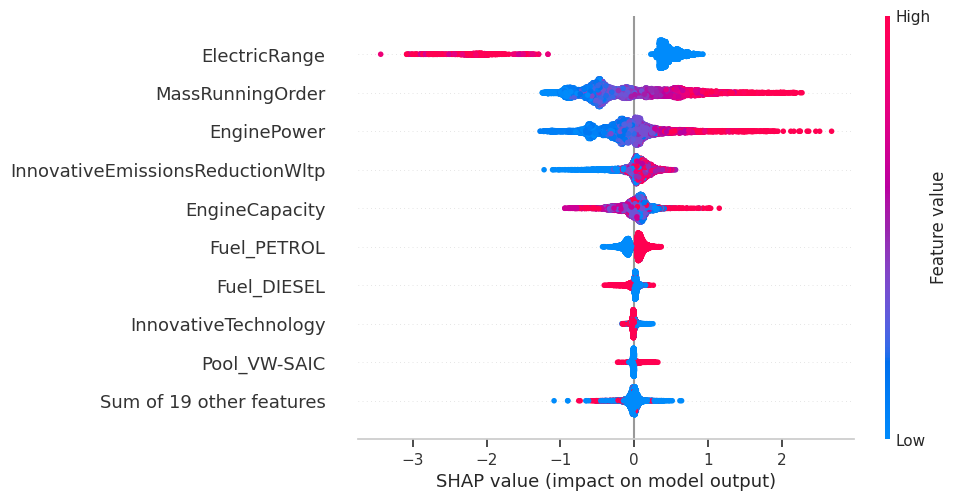

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.force(shap_values[30])

In [ ]:
shap.plots.force(shap_values[-1])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0:300])


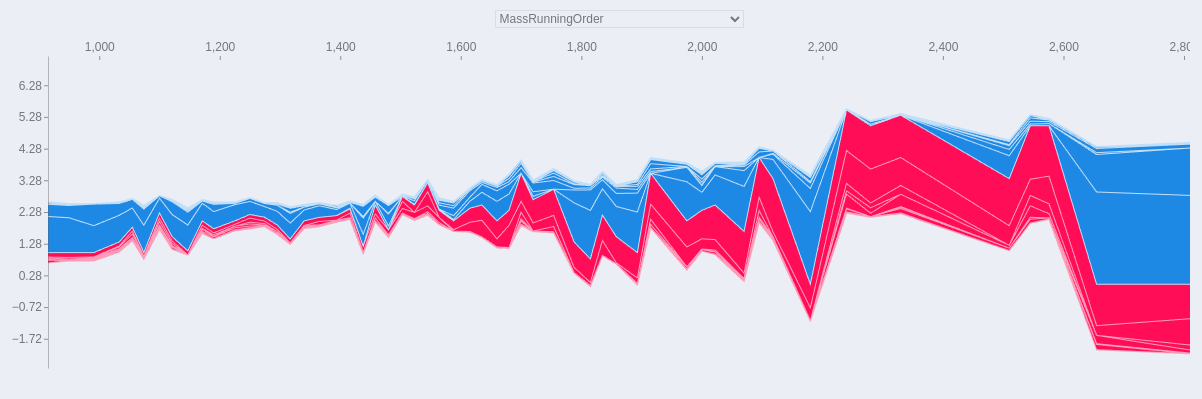²

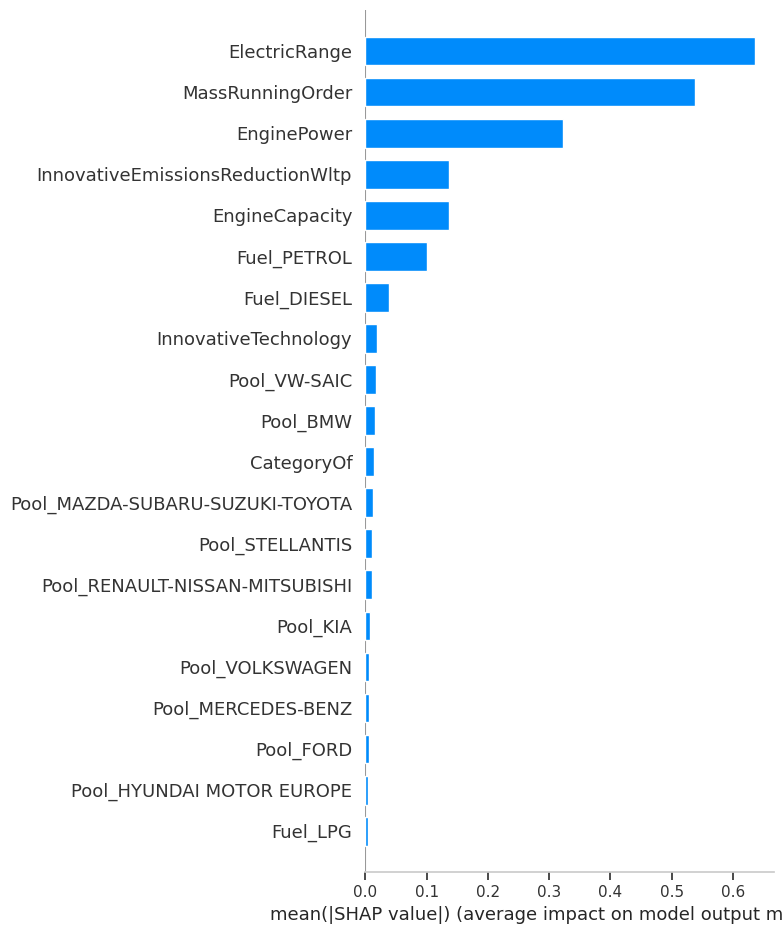

: 

In [ ]:
shap.summary_plot(shap_values, X_test_x, plot_type='bar', feature_names=X_test_x.columns)